# Система оценки риска ДТП на выбранном маршруте движения

# Содержание

- [Введение](#intro)
- [Подключение к базе](#db_connect)
- [Исследование таблиц](#tables)
  - [Выводы по исследованию таблиц](#tables_conclusion)
- [Статистический анализ факторов ДТП](#stat_analysis)
  - [Вывод по статистическому анализу](#stat_analysis_conclusion)
- [Модель для оценки риска](#model)
  - [Подготовка данных](#data_preparation)
  - [Логистическая Регрессия](#log_reg)
  - [Древо Решений](#dt)
  - [Случайный Лес](#rf)
  - [Catboost](#catboost)
  - [Лучшая модель на тестовых данных](#best_model)
  - [Вывод по модели](#model_conclusion)
- [Анализ важности факторов ДТП](#factors_analysis)
- [Выводы](#conclusion)

<a id='intro'></a>
## Введение

Нам поступил заказв каршеринговой компании: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Нам предоставлен доступ к базе данных по происшествиям. Подключимся к неё, изучим находящиеся там данные. От заказчика так же есть условие: для создания моделей ограничится данными за 2012 год, а так же учитывать фактор возраста автомобиля. После изучения данных, построим несколько моделей для предстаказния ДТП, изучим основные факторы которые могут привести к ДТП. По результатам сделаем выводы такие как возможно ли создание такой системы с хорошим качеством, а так же стоит ли учитывать какие-то факторы о которых нет сведений в данной базе.

<a id='db_connect'></a>
## Подключимся к базе. Загрузим таблицы sql

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from statistics import mean

from sqlalchemy import create_engine, inspect

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

**Конфигурация для подключения к базе**

**!!! Данные которые использовались для работы с базой изменены на заглушки: user, password и тд. !!!**

In [2]:
db_config = {
'user': 'user',
'pwd': 'password',
'host': 'host',
'port': 1111,
'db': 'data-science-vehicle-db'
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

**Подключаемся к базе**

In [3]:
engine = create_engine(connection_string) 

К базе поключились, можем приступить к извлечению информации.

**Получаем информацию о базе**

In [4]:
inspector = inspect(engine)

In [5]:
table_names = inspector.get_table_names()

print("Table Names:", table_names)

Table Names: ['case_ids', 'collisions', 'parties', 'vehicles']


В базе данных находятся 4 таблицы `case_ids`, `collisions`, `parties`, `vehicles`. Извлечём их и сохраним как pandas DataFrame.

In [6]:
query = '''
SELECT *
FROM vehicles;
'''

vehicles = pd.read_sql_query(query, con=engine)

In [7]:
query = '''
SELECT *
FROM collisions;
'''

collisions = pd.read_sql_query(query, con=engine)

In [8]:
query = '''
SELECT *
FROM parties;
'''

parties = pd.read_sql_query(query, con=engine)

In [9]:
query = '''
SELECT *
FROM case_ids;
'''

case_ids = pd.read_sql_query(query, con=engine)

Данные извлечены. Теперь можем приступать к изучению таблиц.

<a id='tables'></a>
## Проведём первичное исследование таблиц

In [10]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


В таблице vehicles 6 столбцов и 1021234 строк. Столбец `id` - первичный ключ, `case_id` - внешний. Названия стобцов совпадают с предоствленным описанием данных.

In [11]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

В таблице collisions 20 столбцов и 1400000 строк. Столбец `case_id` - первичный ключ. Названия стобцов совпадают с предоствленным описанием данных.

In [12]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


В таблице parties 9 столбцов и 2752408 строк. Столбец `id` - первичный ключ, `case_id` - внешний. Названия стобцов совпадают с предоствленным описанием данных.

In [13]:
case_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


В таблице `case_ids` 2 столбца и 1400000 строк. Столбец case_id - первичный ключ. Названия стобцов не совпадают с предоствленным описанием данных. В предоставленной ER-диаграмме нет столбца `db_year` вместо него должен быть `Case_id`. Далее посмотрим что находится в данном столбце.

Количество таблиц совпадает с предоставленной ER-диаграммой. В таблице `vehicles` находится меньше значений чем должно быть. Во всех таблицах кроме `case_ids` количество и название стобцов совпадает с полученным описанием данных.

Посмотрим на **case_ids**.

In [14]:
query = '''
SELECT DISTINCT db_year
FROM case_ids;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,db_year
0,2021


Ранее мы узнали что в `case_ids` 1400000 строк и данная таблица является связующей для всех остальных в данной базе, колонка `case_ids` является первичным ключом с которым связаны остальные таблицы с внешними ключами с аналогичным названием.

Во второй колонке `db_year`, во всех строках находится одно значение - 2021. Можем предположить что это год когда база последний раз обновлялась.

Пропуски в таблице отсутствуют.

Посмотрим на **vehicles**.

In [15]:
query = '''
SELECT COUNT(DISTINCT case_id)
FROM vehicles;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,count
0,792642


Таблица содержит пропуски, нашли только 792642 уникальных значения в case_id в то время как их должно было быть 1400000.

In [16]:
query = '''
SELECT DISTINCT vehicle_type
FROM vehicles
ORDER BY vehicle_type;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,vehicle_type
0,coupe
1,hatchback
2,minivan
3,other
4,sedan


В таблице есть 4 типа кузовов, пропусков нет.

In [17]:
query = '''
SELECT DISTINCT vehicle_transmission
FROM vehicles
ORDER BY vehicle_transmission;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,vehicle_transmission
0,auto
1,manual
2,None


В таблице есть пропуски в `vehicle_transmission`. Кроме пропусков присутствуют два типа значений auto и manual. В описании третий тип должен быть "Not Stated (Не указано)". В дальнейшем будем считать что пропуски относят к этому типу.

In [18]:
query = '''
SELECT vehicle_age,
       COUNT(*)
FROM vehicles
GROUP BY vehicle_age
ORDER BY vehicle_age;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,vehicle_age,count
0,0.0,40262
1,1.0,41307
2,2.0,106530
3,3.0,178550
4,4.0,125472
5,5.0,105035
6,6.0,84362
7,7.0,84282
8,8.0,77070
9,9.0,58255


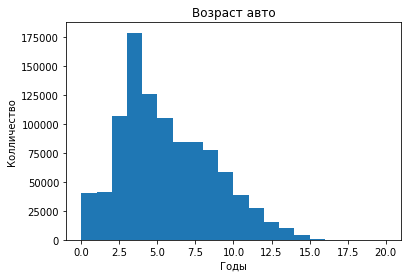

In [19]:
fig, ax = plt.subplots()
ax.hist((vehicles['vehicle_age']), bins=20, range=(0, 20));
ax.set_title('Возраст авто')
ax.set_xlabel('Годы')
ax.set_ylabel('Колличество')
plt.show()

В `vehicle_age` есть аномалия в виде возраста автомобиля - 161 год, а так же есть пропущенные значения. Нашли 17 аномальных значений и 24582 пропуска. График выглядит логично с пиком около 3 лет.

Посмотрим на **parties**.

In [20]:
query = '''
SELECT COUNT(DISTINCT case_id)
FROM parties;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,count
0,1400000


До этого мы выяснили из таблицы `case_ids` что в базе находятся 1400000 происшествия, проверили что в таблице `parties` такое же количество. Данные совпадают.

In [21]:
query = '''
SELECT party_number,
       COUNT(*)
FROM parties
GROUP BY party_number
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,party_number,count
0,1,1399990
1,2,1125221
2,3,177996
3,4,37688
4,5,8295
5,6,2079
6,7,631
7,8,245
8,9,105
9,10,58


Количество участников происшествия варьируется от 1 до 27. Наиболее распространённое количество 1-3.

In [22]:
query = '''
SELECT party_type,
       COUNT(*)
FROM parties
GROUP BY party_type
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,party_type,count
0,car,2469314
1,road bumper,173488
2,building,48649
3,road signs,48456
4,other,8879
5,None,3622


Нашли 5 типов участников происшествия, а также пропуски в количестве 3622. Наиболее распространённый тип - car. В описании ещё присутсвуют типы "Operator (Оператор)" и "Not Stated (Не указано)". В дальнейшем примем пропуски за "Not Stated".

,at_fault,count
0,0,1464281
1,1,1288127


0    0.532
1    0.468
Name: count, dtype: float64


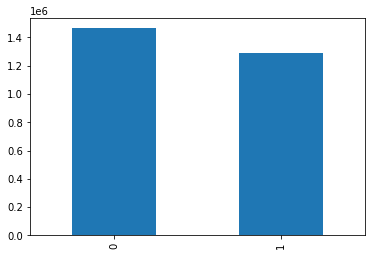

In [23]:
query = '''
SELECT at_fault,
       COUNT(*)
FROM parties
GROUP BY at_fault
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)
print(q['count'] / q['count'].sum())
q['count'].plot(kind='bar');

Виновность участника распределена с небольшим уклоном в сторону отсутсвия вины. Пропусков нет.

In [24]:
query = '''
SELECT insurance_premium,
       COUNT(*)
FROM parties
GROUP BY insurance_premium
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,insurance_premium,count
0,NaN,405402
1,19.0,77571
2,20.0,75488
3,21.0,73366
4,22.0,69329
...,...,...
102,102.0,52
103,103.0,39
104,101.0,37
105,104.0,34


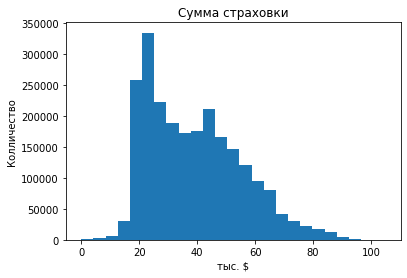

In [25]:
fig, ax = plt.subplots()
ax.hist((parties['insurance_premium']), bins=25);
ax.set_title('Сумма страховки')
ax.set_xlabel('тыс. $')
ax.set_ylabel('Колличество')
plt.show()

По сумме страховки нашли 405402 пропуска. Самые распрастранённые значения приходятся на диапазон примерно 19-23 тыс $. Можем предположить что пропуски это отсутсвие страховки.

In [26]:
query = '''
SELECT party_sobriety,
       COUNT(*)
FROM parties
GROUP BY party_sobriety
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,party_sobriety,count
0,had not been drinking,2124727
1,impairment unknown,232901
2,not applicable,169343
3,"had been drinking, under influence",112413
4,None,73955
5,"had been drinking, impairment unknown",21419
6,"had been drinking, not under influence",17650


В тезвости участников нашли 73955 пропусков. Наиболее часто значение - "не пил". В описании есть категория "Not Stated (Не указано)", в будущем пропуски примем на эту категорию. Категории совпадают с описанием, только ещё должно присутствывать буквенное обозначение, например "A — Had Not Been Drinking".

In [27]:
query = '''
SELECT party_drug_physical,
       COUNT(*)
FROM parties
GROUP BY party_drug_physical
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,party_drug_physical,count
0,None,2320120
1,G,232901
2,not applicable,169343
3,under drug influence,13215
4,sleepy/fatigued,12641
5,impairment - physical,4188


В состоянии участника нашли 2320120 пропуска, это самое распространённое значение, за ним следует G. В описании есть категория "Not Stated (Не указано)", в будущем пропуски примем на эту категорию. Как и в столбце `party_sobriety` тут в названии категории так же есть буквеннно обозначени + название. Например вместо G должно быть "G — Impairment Unknown" или вместо названий только буквенные обозначения. В остальном названия соответсвуют описанию.

In [28]:
query = '''
SELECT cellphone_in_use,
       COUNT(*)
FROM parties
GROUP BY cellphone_in_use
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,cellphone_in_use,count
0,0.0,2194946
1,NaN,511637
2,1.0,45825


В наличии телефона нашли пропуски - 511637. Наиболее распространённое значение 0 - отсутствие телефона. Можем предположить что пропуски это отсутсвие телефона или создадим третью категорию "Unknown" обозначающую что информации о наличии или об отсутсвии телефона не имеется. В дальнейшем, когда будем готовить даннные для модели, решим что делать с этими пропусками.

Посмотрим на **collisions**.

In [29]:
query = '''
SELECT COUNT(DISTINCT case_id)
FROM collisions;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,count
0,1400000


Количество `case_id` совпадает со значением в таблице `case_ids`.

In [30]:
query = '''
SELECT direction,
       COUNT(*)
FROM collisions
GROUP BY direction
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,direction,count
0,None,340642
1,south,290513
2,north,288614
3,east,240574
4,west,239657


В направлении движения есть пропуски - 340642. Данные распределены более менее равномерно. В описании есть категория "Not Stated (Не указано)", в будущем пропуски примем на эту категорию

In [31]:
query = '''
SELECT intersection,
       COUNT(*)
FROM collisions
GROUP BY intersection
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,intersection,count
0,0.0,1075657
1,1.0,312124
2,NaN,12219


В описании у нас есть три категории:
- Y — Intersection (перекрёсток)
- N — Not Intersection (не перекрёсток)
- Not stated (Не указано)

По данной логике предположим что что 0 это N, а 1 - Y. Пропуски примем за "Not stated".

In [32]:
query = '''
SELECT weather_1,
       COUNT(*)
FROM collisions
GROUP BY weather_1
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,weather_1,count
0,clear,1121048
1,cloudy,203030
2,raining,57976
3,None,7259
4,fog,6156
5,snowing,2571
6,other,1516
7,wind,444


Нашли 7259 пропуска в `weather_1`. Наиболее часто встречающаяся погода - clear. Пропуски примем за "Not stated".

In [33]:
query = '''
SELECT location_type,
       COUNT(*)
FROM collisions
GROUP BY location_type
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,location_type,count
0,None,881221
1,highway,416531
2,ramp,75592
3,intersection,26656


Нашли 881221 пропуска, примем из за "Not State Highway" из предоставленного описания данных.

In [34]:
query = '''
SELECT collision_damage,
       COUNT(*)
FROM collisions
GROUP BY collision_damage
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,collision_damage,count
0,small damage,845771
1,scratch,346106
2,middle damage,166583
3,severe damage,30747
4,fatal,10793


Пропусков нет. Наиболее частое повреждение "small damage" и "scratch".

In [35]:
query = '''
SELECT party_count,
       COUNT(*)
FROM collisions
GROUP BY party_count
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,party_count,count
0,2,947251
1,1,274766
2,3,140300
3,4,29389
4,5,6217
5,6,1446
6,7,386
7,8,140
8,9,47
9,10,30


Количество участников варируется от 1 до 27.

In [36]:
query = '''
SELECT primary_collision_factor,
       COUNT(*)
FROM collisions
GROUP BY primary_collision_factor
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,primary_collision_factor,count
0,vehicle code violation,1316453
1,unknown,37014
2,other than driver,29780
3,other improper driving,8470
4,None,8166
5,fell asleep,117


Нашли 8166 пропуска, примем их за "Not Stated". Наиболее частый фактор аварии - "Нарушение правил ПДД".

In [37]:
query = '''
SELECT pcf_violation_category,
       COUNT(*)
FROM collisions
GROUP BY pcf_violation_category
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,pcf_violation_category,count
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962
5,traffic signals and signs,72751
6,unsafe starting or backing,55674
7,unknown,39558
8,wrong side of road,33631
9,following too closely,30033


Нашли 27954 пропуска. Количество категорий совпадает с предоставленным описанием, пропуски примем за "Not Stated".

In [38]:
query = '''
SELECT type_of_collision,
       COUNT(*)
FROM collisions
GROUP BY type_of_collision
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,type_of_collision,count
0,rear end,467109
1,broadside,267368
2,sideswipe,241278
3,hit object,234024
4,other,78750
5,head-on,60059
6,overturned,39588
7,None,11824


Нашли 11824 пропуска. В описании ещё есть категории "G — Vehicle" и "Not Stated". Пропуски примем за "Not Stated"

In [39]:
query = '''
SELECT motor_vehicle_involved_with,
       COUNT(*)
FROM collisions
GROUP BY motor_vehicle_involved_with
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,motor_vehicle_involved_with,count
0,other motor vehicle,891079
1,fixed object,226942
2,parked motor vehicle,104423
3,other object,72677
4,bicycle,41711
5,non-collision,39905
6,motor vehicle on other roadway,9831
7,None,6819
8,animal,6191
9,train,422


В описании есть категория "pedestrian", нашедшие пропуски (6819) отнесём к этой категории.

In [40]:
query = '''
SELECT road_surface,
       COUNT(*)
FROM collisions
GROUP BY road_surface
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,road_surface,count
0,dry,1242026
1,wet,136236
2,None,13093
3,snowy,7261
4,slippery,1384


Нашли пропуска в колличестве 13093, отнесём их к категории "Not Stated". Наиболее распростанённое состояние поверхности - dry.

In [41]:
query = '''
SELECT road_condition_1,
       COUNT(*)
FROM collisions
GROUP BY road_condition_1
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,road_condition_1,count
0,normal,1346655
1,construction,19332
2,None,11988
3,other,5688
4,holes,5484
5,obstruction,5276
6,loose material,2887
7,reduced width,1576
8,flooded,1114


Нашли 11988 пропуска, примем их за "Not Stated". Наиболее частое состояние дороги - normal.

In [42]:
query = '''
SELECT lighting,
       COUNT(*)
FROM collisions
GROUP BY lighting
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,lighting,count
0,daylight,941950
1,dark with street lights,291887
2,dark with no street lights,106170
3,dusk or dawn,47199
4,None,8593
5,dark with street lights not functioning,4201


Нашли 8593 пропуска, примем их за "Not Stated". Наиболее частое состояние освещения - daylight.

In [43]:
query = '''
SELECT control_device,
       COUNT(*)
FROM collisions
GROUP BY control_device
ORDER BY COUNT DESC;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,control_device,count
0,none,916182
1,functioning,470849
2,None,8407
3,not functioning,3833
4,obscured,729


Нашли 8407 пропуска, примем их за "Not Stated". Наиболее частое устройство управление - None (Нет).

In [44]:
query = '''
SELECT collision_date,
       COUNT(*)
FROM collisions
GROUP BY collision_date
ORDER BY collision_date;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,collision_date,count
0,2009-01-01,1001
1,2009-01-02,1072
2,2009-01-03,908
3,2009-01-04,699
4,2009-01-05,1084
...,...,...
1545,2013-04-30,1
1546,2013-06-05,1
1547,2013-07-08,1
1548,2020-03-14,1


По столбцу с датой происшествия определили что в базе присутсвуют данные за период с Января 2009 года по Июль 2020 года.

In [45]:
query = '''
SELECT COUNT(*)
FROM collisions
WHERE collision_time IS NULL;
'''

q = pd.read_sql_query(query, con=engine)
display(q)

,count
0,12308


Нашли 12308 пропусков в колонке со временем происшествия, эти данные мы не будем использовать.

<a id='tables_conclusion'></a>
### Выводы по исследованию таблиц

Изучили предоставленные таблицы: `case_ids`, `vehicles` ,`parties` и `collisions`. Количество таблиц соответсвует описанию данных, таблицы имеют ключ для их связи `case_id` через промежуточную таблицу `case_ids`. Все таблицы кроме `vehicles` имеют данные о 1400000 происшествиях, в `vehicles` только о 792642, тоесть только 57% от общего количества. Из-за того что у нас есть обязательное условие учитывать фактор возраста автомобиля который находится в этой таблицы, мы не сможем использовать больше данных игнорируя этот фактор.

- В таблице `case_ids` есть несостыковка с описанием, столбца `db_year` там нет, зато должен быть `Case_id`. В `db_year` находится только одно значение во всех строках - 2021, сделали предположение что это год последнего обновление базы, нам этот столбец не понадобится, а вот `case_id` критичестки важный, он содержит первичный ключ который связывает все остальные таблицы.
- В таблице `vehicles` столбцы совпадают с описанием, данные в целом заполнены корректными значениями. В таблице присутсвуют аномалии в стобце `vehicle_age` в виде возраста автомобиля - 161 год, а так нашли 24582 пропуска. В таблицы имеются данные не о всех просшествиях занесённых в данную базу, только о 792642 из 1400000.
- В таблице `parties` столбцы совпадают с описанием. Имеются данные о всех просшествиях в базе. Аномалии отсутсвуют.
- В таблице `collisions` столбцы совпадают с описанием. Данные есть о всех происшествиях. Присутсвуют пропуски которые мы в дальнейшем не будет использовать - 12308 пропусков в столбце со временем просшествия.

<a id='stat_analysis'></a>
##  Проведём статистический анализ факторов ДТП

Выясним на какие месяц приходится больше всего происшествий. Запросом извлечём необходимые данные и построим график.

In [46]:
query = '''
SELECT DISTINCT EXTRACT(MONTH FROM collision_date) AS num_of_month,
       EXTRACT(YEAR FROM collision_date) AS num_of_year,
       COUNT(case_id) OVER (PARTITION BY  EXTRACT(YEAR FROM collision_date), EXTRACT(MONTH FROM collision_date))
FROM collisions
ORDER BY EXTRACT(YEAR FROM collision_date);
'''

collisions_by_month = pd.read_sql_query(query, con=engine)
display(collisions_by_month)

,num_of_month,num_of_year,count
0,1.0,2009.0,35062
1,2.0,2009.0,34480
2,3.0,2009.0,36648
3,4.0,2009.0,35239
4,5.0,2009.0,36916
5,6.0,2009.0,34202
6,7.0,2009.0,35161
7,8.0,2009.0,34508
8,9.0,2009.0,35555
9,10.0,2009.0,37835


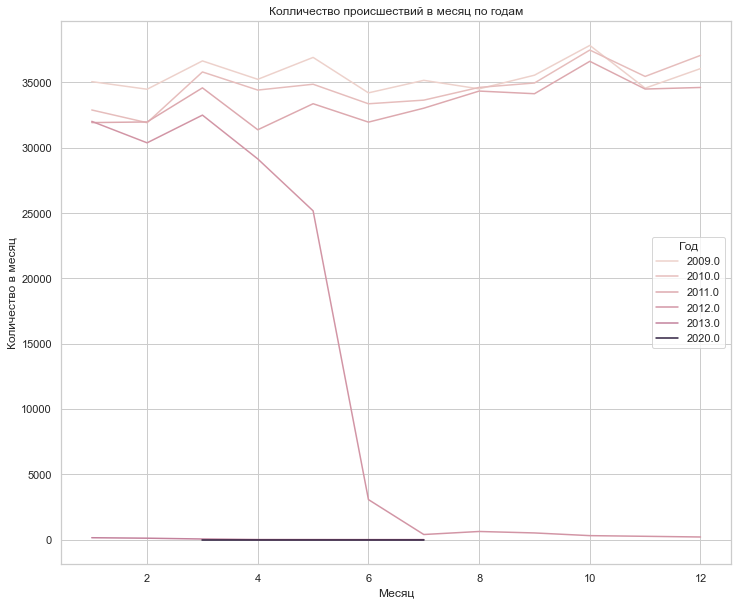

In [47]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))
sns.lineplot(data=collisions_by_month, x="num_of_month", y="count", hue="num_of_year")
plt.title("Колличество происшествий в месяц по годам")
plt.xlabel("Месяц")
plt.ylabel("Количество в месяц")
plt.legend(title="Год")
plt.show()

Видим что начиная с лета 2012 года количество данных снижается вплоть до полной пропажи летом 2013 года. До этого видим что наиболее опасный месяц октябрь, в целом количество аварий в течении года по месяцам приходится более менее равномерно. Сделаем ещё один запрос где дынне ограничим до 2011 включительно и построим стобчатковую диаграмму.

In [48]:
query = '''
SELECT EXTRACT(MONTH FROM collision_date) AS num_of_month,
       COUNT(case_id) AS num_of_collisions
FROM collisions
WHERE collision_date < '2011-12-31'
GROUP BY EXTRACT(MONTH FROM collision_date)
ORDER BY num_of_collisions DESC;
'''

col_by_month_befor_2011 = pd.read_sql_query(query, con=engine)
display(col_by_month_befor_2011)

,num_of_month,num_of_collisions
0,10.0,111933
1,3.0,107036
2,12.0,106972
3,5.0,105148
4,9.0,104649
5,11.0,104517
6,8.0,103467
7,7.0,101835
8,4.0,101032
9,1.0,99880


Данные извлекли, построим стобчатковую диаграмму.

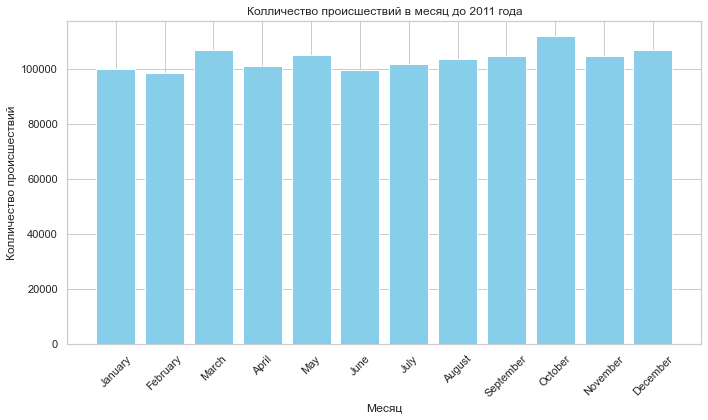

In [49]:
month_name_mapping = {i: calendar.month_name[i] for i in range(1, 13)}
col_by_month_befor_2011['month_name'] = col_by_month_befor_2011['num_of_month'].map(month_name_mapping)

col_by_month_befor_2011 = col_by_month_befor_2011.sort_values('num_of_month')

plt.figure(figsize=(10, 6))
plt.bar(col_by_month_befor_2011['month_name'], col_by_month_befor_2011['num_of_collisions'], color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Колличество происшествий')
plt.title('Колличество происшествий в месяц до 2011 года')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Диаграмму построили, предыдущие выводы подтвердились.

Напишем несколько задач для коллег которые стоит проанализировать и сделать выводы по ним. Часть из них разберём тут.

Задачи:

1) Проанализировать влияние состояния дороги на серьёзность повреждения автомобиля. Данные необходимые для данной задачи можно найти в таблицах collisions и parties. Сделать график по извлёченным значениям и сделать вывод по нему.

2) Определить кто из участников аварии наиболее склонен оказаться её виновником. Под участником понимается - авто, отбойник и тд. Данных необходимых для решения достаточно в таблице parties. Сделать график по извлёченным значениям и сделать вывод по нему.

3) Оценить насколько трезвость водителя связана с причиной аварий. Данных необходимых для решения достаточно в таблице parties. Сделать график по извлёченным значениям и сделать вывод по нему.

4) Аналогично предыдущей задаче, оценить насколько состояние участника: физическое или с учётом принятых лекарств может быть причиной аварии. Данных необходимых для решения достаточно в таблице parties. Сделать график по извлёченным значениям и сделать вывод по нему.

5) Оценить, может ли возраст автомобиля бять связан с причиной аварии. Данные необходимые для данной задачи можно найти в таблицах vehicles и parties. Сделать график по извлёченным значениям и сделать вывод по нему.

6) Определить как освещение может влиять на создание аварий. Данные необходимые для данной задачи можно найти в таблицах collisions и parties. Сделать график по извлёченным значениям и сделать вывод по нему.

Посмотрим на серьезность повреждения автомобиля исходя из состояния дороги.

In [50]:
query = '''
SELECT c.road_condition_1,
       c.collision_damage
FROM collisions AS c
  INNER JOIN parties AS p ON c.case_id = p.case_id
WHERE p.party_type = 'car';
'''

dmg_by_road_cond = pd.read_sql_query(query, con=engine)
display(dmg_by_road_cond)

,road_condition_1,collision_damage
0,normal,small damage
1,normal,small damage
2,normal,small damage
3,normal,small damage
4,normal,scratch
...,...,...
2469309,normal,small damage
2469310,normal,severe damage
2469311,normal,small damage
2469312,normal,middle damage


Данные извлекли, получили 2469314 авто попавших в происшествия с различной степенью повреждения. Как выяснили ранее в road_condition_1 есть пропуски которые решили заполнить значением *not stated*.

In [51]:
dmg_by_road_cond['road_condition_1'] = dmg_by_road_cond['road_condition_1'].fillna('not stated')

In [52]:
dmg_by_road_cond.isna().sum()

road_condition_1    0
collision_damage    0
dtype: int64

Заполнили пропуски, проверили что теперь они отсутсвуют. Посмотрим теперь как распределены типы повреждений исходя из состояние дороги.

In [53]:
unique_road_conditions = dmg_by_road_cond['road_condition_1'].unique()
unique_damage_levels = dmg_by_road_cond['collision_damage'].unique()

print("Unique Road Conditions:", unique_road_conditions)
print("Unique Damage Levels:", unique_damage_levels)

Unique Road Conditions: ['normal' 'other' 'construction' 'flooded' 'obstruction' 'not stated'
 'holes' 'reduced width' 'loose material']
Unique Damage Levels: ['small damage' 'scratch' 'middle damage' 'severe damage' 'fatal']


In [54]:
analysis = dmg_by_road_cond.groupby('road_condition_1')['collision_damage'].value_counts(normalize=True).unstack()
print(analysis)

collision_damage     fatal  middle damage   scratch  severe damage  \
road_condition_1                                                     
construction      0.008609       0.088962  0.255146       0.017192   
flooded           0.004439       0.119848  0.264426       0.017121   
holes             0.003362       0.115051  0.282802       0.020278   
loose material    0.012305       0.163795  0.195242       0.041564   
normal            0.006362       0.105092  0.275281       0.017970   
not stated        0.005084       0.098495  0.290848       0.016848   
obstruction       0.008933       0.093675  0.213544       0.022091   
other             0.009170       0.115637  0.241038       0.025962   
reduced width     0.004723       0.082009  0.182911       0.013310   

collision_damage  small damage  
road_condition_1                
construction          0.630091  
flooded               0.594166  
holes                 0.578508  
loose material        0.587093  
normal                0.595295 

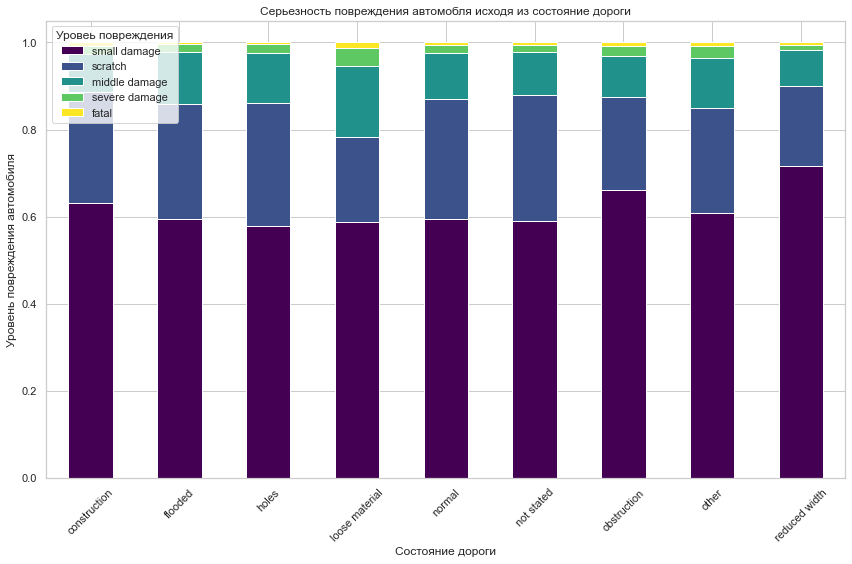

In [55]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

analysis = analysis.reindex(columns=unique_damage_levels)

analysis.plot(kind='bar', stacked=True, colormap='viridis')

plt.title("Серьезность повреждения автомобля исходя из состояние дороги")
plt.xlabel("Состояние дороги")
plt.ylabel("Уровень повреждения автомобиля")
plt.xticks(rotation=45)
plt.legend(title="Уровеь повреждения", loc='upper left')
plt.tight_layout()

plt.show()

Видим что loose matrial (Сыпучий материал на проезжей части) являтся наиболее опасным состоянием дороги, оно вызывает более тяжелые повреждения автомобиля -  самая частая причина происшествий "Не подлежит восстановлению", а также "Серьёзный ремонт, большая часть под замену" и "Средний ремонт, машина в целом на ходу". Меньше всего повреждений связаны с состояниями - "Уменьшенная ширина проезжей части" и "Ямы, глубокая колея". Ямы являются частой причиной царапин, в то время как уменьшнная ширина - мелких повреждений.

Посмотрим на наиболее частый тип виновника ДТП.

In [56]:
query = '''
SELECT DISTINCT party_type,
       at_fault,
       COUNT(id) OVER (PARTITION BY party_type) AS total,
       COUNT(id) OVER (PARTITION BY party_type, at_fault) AS num_of_fault
FROM parties;
'''

party_type = pd.read_sql_query(query, con=engine)
display(party_type)

,party_type,at_fault,total,num_of_fault
0,building,0,48649,21322
1,building,1,48649,27327
2,car,0,2469314,1228964
3,car,1,2469314,1240350
4,other,0,8879,7118
5,other,1,8879,1761
6,road bumper,0,173488,171898
7,road bumper,1,173488,1590
8,road signs,0,48456,33192
9,road signs,1,48456,15264


Данные извлекли, заполним пропуски в `party_type` как *not stated*.

In [57]:
party_type['party_type'] = party_type['party_type'].fillna('not stated')

In [58]:
party_type.isna().sum()

party_type      0
at_fault        0
total           0
num_of_fault    0
dtype: int64

Пропуски заполнили. Посмотрим на процентное соотношение виновных типов участников ДТП.

In [59]:
party_type = party_type.loc[party_type['at_fault'] !=0]
party_type = party_type.drop(['at_fault'], axis=1).reset_index(drop=True)

In [60]:
party_type.loc[:, 'perc_of_fault'] = ((party_type['num_of_fault'] / party_type['total']) * 100)
party_type = party_type.sort_values(by='perc_of_fault', ascending=False)

display(party_type)

,party_type,total,num_of_fault,perc_of_fault
0,building,48649,27327,56.171761
5,not stated,3622,1835,50.662617
1,car,2469314,1240350,50.230550
4,road signs,48456,15264,31.500743
2,other,8879,1761,19.833315
3,road bumper,173488,1590,0.916490


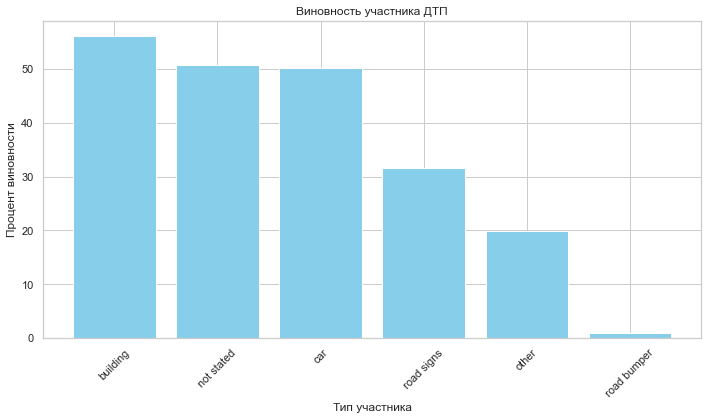

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(party_type['party_type'], party_type['perc_of_fault'], color='skyblue')
plt.xlabel('Тип участника')
plt.ylabel('Процент виновности')
plt.title('Виновность участника ДТП')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Выяснили что здания являются в 56% случаев виновником просшествия если они присутствуют, что является наибольшим процентом, следом идут "Не указано" и "Авто" у которых по 50%. Самый редкий виновник аварии "Дорожные знаки", только в 0.9% случаем они виноваты.

Посмотрим на влияние трезвости участника на аварию.

In [62]:
query = '''
SELECT DISTINCT party_sobriety,
       at_fault,
       COUNT(id) OVER (PARTITION BY party_sobriety) AS total,
       COUNT(id) OVER (PARTITION BY party_sobriety, at_fault) AS num_of_fault
FROM parties;
'''

party_sobriety = pd.read_sql_query(query, con=engine)
display(party_sobriety)

,party_sobriety,at_fault,total,num_of_fault
0,"had been drinking, impairment unknown",0,21419,4367
1,"had been drinking, impairment unknown",1,21419,17052
2,"had been drinking, not under influence",0,17650,5706
3,"had been drinking, not under influence",1,17650,11944
4,"had been drinking, under influence",0,112413,6467
5,"had been drinking, under influence",1,112413,105946
6,had not been drinking,0,2124727,1195907
7,had not been drinking,1,2124727,928820
8,impairment unknown,0,232901,50177
9,impairment unknown,1,232901,182724


Данные извлекли, заполним пропуски в `party_sobriety` как *not stated*.

In [63]:
party_sobriety['party_sobriety'] = party_sobriety['party_sobriety'].fillna('not stated')

In [64]:
party_sobriety.isna().sum()

party_sobriety    0
at_fault          0
total             0
num_of_fault      0
dtype: int64

Пропуски заполнили. Посмотрим на процентное соотношение состояния к вине.

In [65]:
party_sobriety = party_sobriety.loc[party_sobriety['at_fault'] !=0]
party_sobriety = party_sobriety.drop(['at_fault'], axis=1).reset_index(drop=True)

In [66]:
party_sobriety.loc[:, 'perc_of_fault'] = ((party_sobriety['num_of_fault'] / party_sobriety['total']) * 100)
party_sobriety = party_sobriety.sort_values(by='perc_of_fault', ascending=False)

display(party_sobriety)

,party_sobriety,total,num_of_fault,perc_of_fault
2,"had been drinking, under influence",112413,105946,94.247107
0,"had been drinking, impairment unknown",21419,17052,79.611560
4,impairment unknown,232901,182724,78.455653
1,"had been drinking, not under influence",17650,11944,67.671388
3,had not been drinking,2124727,928820,43.714793
6,not stated,73955,28840,38.996687
5,not applicable,169343,12801,7.559214


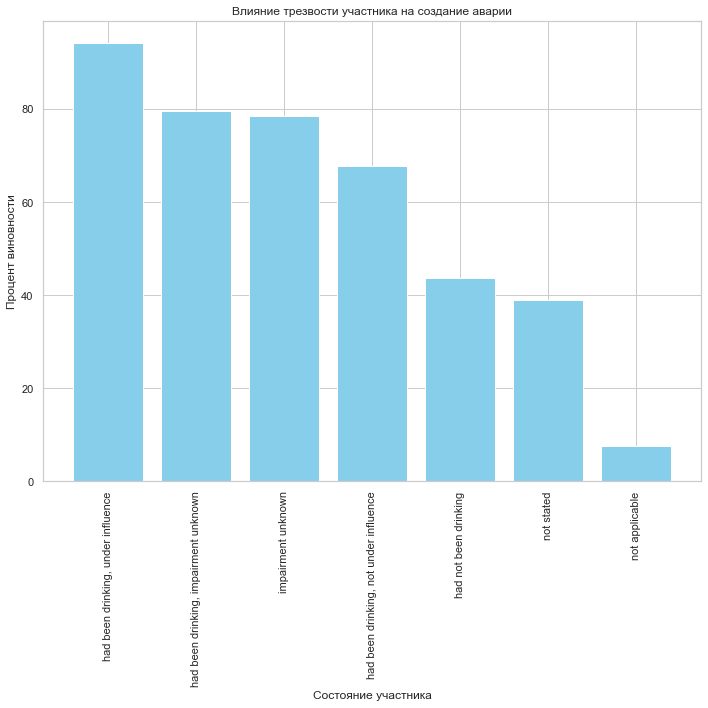

In [67]:
plt.figure(figsize=(10, 10))
plt.bar(party_sobriety['party_sobriety'], party_sobriety['perc_of_fault'], color='skyblue')
plt.xlabel('Состояние участника')
plt.ylabel('Процент виновности')
plt.title('Влияние трезвости участника на создание аварии')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

В 94% при состоянии "Был пьян, под влиянием" данный участник виноват в аварии, после этого следуют "Был пьян, ухудшение неизвестно" и "Неизвестно ухудшение" с 79% и 78% соответсвенно. В тех случаях где участник был трезв, не проверялся или состояние не указало, вина приходится меньше чем в 50% случаев. Можем сделать вывод что данный фактор является важным для оценки потенциальной опастности маршрута.

Посмотрим влияет ли возраст автомобиля на создание аварий.

In [68]:
query = '''
SELECT DISTINCT v.vehicle_age,
       p.at_fault,
       COUNT(p.id) OVER (PARTITION BY v.vehicle_age) AS total,
       COUNT(p.id) OVER (PARTITION BY v.vehicle_age, p.at_fault) AS num_of_fault
FROM vehicles AS v 
  JOIN parties AS p ON v.case_id = p.case_id 
    AND p.party_number = v.party_number;
'''

vehicle_age = pd.read_sql_query(query, con=engine)
display(vehicle_age)

,vehicle_age,at_fault,total,num_of_fault
0,0.0,0,40262,22205
1,0.0,1,40262,18057
2,1.0,0,41307,22958
3,1.0,1,41307,18349
4,2.0,0,106530,48208
5,2.0,1,106530,58322
6,3.0,0,178550,81196
7,3.0,1,178550,97354
8,4.0,0,125472,69044
9,4.0,1,125472,56428


Данные извлекли, пропущенные значения удалим.

In [69]:
vehicle_age = vehicle_age.dropna()
vehicle_age.isna().sum()

vehicle_age     0
at_fault        0
total           0
num_of_fault    0
dtype: int64

In [70]:
vehicle_age = vehicle_age.loc[vehicle_age['at_fault'] !=0]
vehicle_age = vehicle_age.drop(['at_fault'], axis=1).reset_index(drop=True)

Пропуски удалены, посчитаем процент вины по возрасту авто.

In [71]:
vehicle_age.loc[:, 'perc_of_fault'] = ((vehicle_age['num_of_fault'] / vehicle_age['total']) * 100)
vehicle_age = vehicle_age.sort_values(by='perc_of_fault', ascending=False)

display(vehicle_age)

,vehicle_age,total,num_of_fault,perc_of_fault
19,161.0,17,10,58.823529
2,2.0,106530,58322,54.747020
14,14.0,4096,2237,54.614258
3,3.0,178550,97354,54.524783
15,15.0,673,356,52.897474
13,13.0,10126,5222,51.570215
18,19.0,6,3,50.000000
12,12.0,14947,6915,46.263464
17,17.0,31,14,45.161290
4,4.0,125472,56428,44.972584


Проценты посчитали. В данных есть аномалия, возраст 161 год, удалим её. Помимо этого есть несколько значений по которым очеь мало данных таках как возраст 20 лет, только 4 авто. Не будем учитывать возраст где меньше 50 авто в данных.

In [72]:
vehicle_age = vehicle_age.loc[vehicle_age['total'] > 50]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


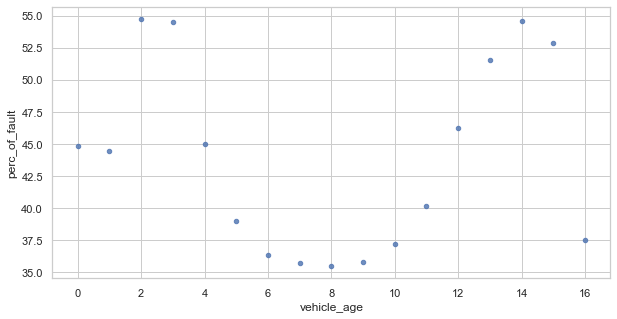

In [73]:
vehicle_age.plot(x='vehicle_age',
                 y='perc_of_fault',
                 kind='scatter',
                 grid=True,
                 alpha=0.8,
                 figsize=(10, 5)
                );

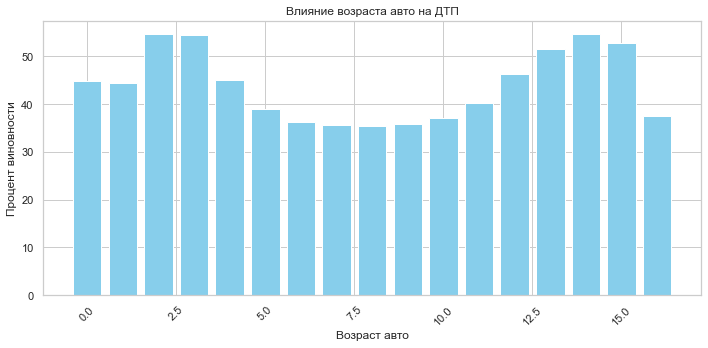

In [74]:
plt.figure(figsize=(10, 5))
plt.bar(vehicle_age['vehicle_age'], vehicle_age['perc_of_fault'], color='skyblue')
plt.xlabel('Возраст авто')
plt.ylabel('Процент виновности')
plt.title('Влияние возраста авто на ДТП')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Узнали что возраст авто никаким образом не влияет на вероятность создания аварий. У всех возрастов процент вины находится в районе 42-45%.

Видим что возраст авто незначительно может влиять на вероятность создания аварий. Есть два пика в районе 52-55% у возрастов около 2-3 лет и 13-15 лет. Наименьший процент в диапазоне 6-9 лет - около 35-36%.

<a id='stat_analysis_conclusion'></a>
### Вывод по статистическому анализу

- Посмотрели в какие месяцы происходит наибольшее количество происшествий. Самым опасный оказался стабильно октябрь, но в целом данные распределены равномерно по месяцам.

- Создали 6 аналитических задач для коллег и некоторые из них рассмотрели здесь.
 - Узнали что возраст авто может влиять на создание аварий.
 - Проверили как состояние участников влияет на аварийность и выяснили что это важный фактор. Участники находящиеся в состоянии алкогольного опьянения намного более склонны к созданию аварийных ситуаций.
 - Остальные задачи или описаны подробно выше или их должны выполнить коллеги.
 
Данные изучены, можем начать их подготовку с создании модели.

<a id='model'></a>
## Создадим модель для оценки водительского риска
<a id='data_preparation'></a>
### Подготовка данных

Напишем запрос с помощь которого получим датасет необходимый для создания модели. 

Основные требования:
- Тип виновника **car**
- Исключить ДТП с типом повреждения **scratch**
- Данные взять только 2012 год.
- В датафрейме должен присутствывать возраст автомобиля.

В запросе так же извлечём только те столбцы которые нам могут понадобится для обучения.
- Из таблицы `parties` извлечём:
 - Целевой признак **at_fault**.
 - **party_sobriet**y, как выяснили выше этот фактор имеет сильное влияние на целевой признак.
 - **party_drug_physical**, потенциально может иметь влияние похожее на **party_sobriety**.
 
- И таблицы `collisions` извлечём:
 - **control_device**, ненадлежащее состояние устройства управления может увеличивать риск аварии.
 - **lighting**, плохое освещение может влиять на целевой признак.
 - **road_condition_1**, ранее выяснили что данный признак вляет на аварии.
 - **road_surface**, предпологаем что состояние дороги может влять на целевой признак.
 - **location_type**, тип дороги предположительно может оказывать влияние на целевой признак, например перекрёстки скорей всего более опасны чем шоссе.
 - **weather_1**, погода может сильно влиять на аварийность.
 
- Из таблицы `vehicles` извлечём:
 - **vehicle_age**, заказчик просит учесть этот фактор.
 - **vehicle_transmission**, тип коробки передач маловероятно, но тем не менее потенциально может влиять на ДТП, учтём его.

In [75]:
query = '''
WITH
p_data AS (SELECT case_id,
                  party_number,
                  at_fault,
                  party_sobriety,
                  party_drug_physical
           FROM parties
           WHERE case_id IN (SELECT case_id  
                             FROM parties
                             WHERE party_type = 'car'
                               AND at_fault = 1)),
                                     
c_data AS (SELECT case_id,
                  control_device,
                  lighting,
                  road_condition_1,
                  road_surface,
                  location_type,
                  weather_1    
           FROM collisions
           WHERE collision_damage != 'scratch'
             AND EXTRACT(YEAR FROM CAST(collision_date AS timestamp)) = 2012),
               
v_data AS (SELECT case_id,
                  party_number,
                  vehicle_transmission,
                  vehicle_age
           FROM vehicles)             
    
SELECT
    c_data.*,
    p_data.*,
    v_data.vehicle_age,
    v_data.vehicle_transmission
FROM
    c_data
JOIN
    p_data ON c_data.case_id = p_data.case_id
LEFT JOIN
    v_data ON p_data.case_id = v_data.case_id 
           AND 
              p_data.party_number = v_data.party_number;
'''

data = pd.read_sql_query(query, con=engine)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   case_id               198481 non-null  object 
 1   control_device        197566 non-null  object 
 2   lighting              197846 non-null  object 
 3   road_condition_1      197445 non-null  object 
 4   road_surface          197279 non-null  object 
 5   location_type         83178 non-null   object 
 6   weather_1             197925 non-null  object 
 7   case_id               198481 non-null  object 
 8   party_number          198481 non-null  int64  
 9   at_fault              198481 non-null  int64  
 10  party_sobriety        193277 non-null  object 
 11  party_drug_physical   34923 non-null   object 
 12  vehicle_age           54027 non-null   float64
 13  vehicle_transmission  54762 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 21

Получили датасет с 198481 строками и 14 столбцами. Теперь займёмся подготовкой его. Нам нужно удалить ненужные колонки которые мы использовали для обьединения таблиц, обработаем пропуски.

In [77]:
data = data.drop(['case_id', 'party_number'], axis=1).reset_index(drop=True)

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   control_device        197566 non-null  object 
 1   lighting              197846 non-null  object 
 2   road_condition_1      197445 non-null  object 
 3   road_surface          197279 non-null  object 
 4   location_type         83178 non-null   object 
 5   weather_1             197925 non-null  object 
 6   at_fault              198481 non-null  int64  
 7   party_sobriety        193277 non-null  object 
 8   party_drug_physical   34923 non-null   object 
 9   vehicle_age           54027 non-null   float64
 10  vehicle_transmission  54762 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 16.7+ MB


Ненужные столбцы удалили. Заполним пропуски в столбцах.

In [79]:
data['control_device'] = data['control_device'].fillna('not stated')
data['lighting'] = data['lighting'].fillna('not stated')
data['road_condition_1'] = data['road_condition_1'].fillna('not stated')
data['road_surface'] = data['road_surface'].fillna('not stated')
data['location_type'] = data['location_type'].fillna('not state highway')
data['weather_1'] = data['weather_1'].fillna('not stated')
data['party_sobriety'] = data['party_sobriety'].fillna('not stated')
data['party_drug_physical'] = data['party_drug_physical'].fillna('not stated')
data['vehicle_transmission'] = data['vehicle_transmission'].fillna('not stated')

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   control_device        198481 non-null  object 
 1   lighting              198481 non-null  object 
 2   road_condition_1      198481 non-null  object 
 3   road_surface          198481 non-null  object 
 4   location_type         198481 non-null  object 
 5   weather_1             198481 non-null  object 
 6   at_fault              198481 non-null  int64  
 7   party_sobriety        198481 non-null  object 
 8   party_drug_physical   198481 non-null  object 
 9   vehicle_age           54027 non-null   float64
 10  vehicle_transmission  198481 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 16.7+ MB


In [81]:
data['vehicle_age'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  19., 161.,  nan])

Остались пропуски в **vehicle_age**, а так же аномалия в виде 161 год. Пропусков много, но мы не можем их заполнить средним или медианой, так как это может сильно исказить данные. Заказчик настаивает на использовании этого стобца, нам нужны чистые данные тут, поэтому решимся на удаление большого колличества значений, ради сохранения чистоты данных в столбце.

In [82]:
data = data.loc[(data['vehicle_age'] < 20)]

In [83]:
data['vehicle_age'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 19.])

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54025 entries, 2 to 198463
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   control_device        54025 non-null  object 
 1   lighting              54025 non-null  object 
 2   road_condition_1      54025 non-null  object 
 3   road_surface          54025 non-null  object 
 4   location_type         54025 non-null  object 
 5   weather_1             54025 non-null  object 
 6   at_fault              54025 non-null  int64  
 7   party_sobriety        54025 non-null  object 
 8   party_drug_physical   54025 non-null  object 
 9   vehicle_age           54025 non-null  float64
 10  vehicle_transmission  54025 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.9+ MB


После обработки пропусков осталось 54025 строк и 11 стобцов. Присутствуют столбцы с неправильным типом данных, произведём замену.

In [85]:
data['at_fault'] = data['at_fault'].astype('int8')
data['vehicle_age'] = data['vehicle_age'].astype('int8')

Замену произвели.

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54025 entries, 2 to 198463
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   control_device        54025 non-null  object
 1   lighting              54025 non-null  object
 2   road_condition_1      54025 non-null  object
 3   road_surface          54025 non-null  object
 4   location_type         54025 non-null  object
 5   weather_1             54025 non-null  object
 6   at_fault              54025 non-null  int8  
 7   party_sobriety        54025 non-null  object
 8   party_drug_physical   54025 non-null  object
 9   vehicle_age           54025 non-null  int8  
 10  vehicle_transmission  54025 non-null  object
dtypes: int8(2), object(9)
memory usage: 4.2+ MB


In [87]:
data.head()

,control_device,lighting,road_condition_1,road_surface,location_type,weather_1,at_fault,party_sobriety,party_drug_physical,vehicle_age,vehicle_transmission
2,none,daylight,other,dry,not state highway,cloudy,0,had not been drinking,not stated,2,auto
6,none,daylight,normal,dry,not state highway,clear,0,had not been drinking,not stated,5,auto
8,functioning,dark with street lights,normal,dry,not state highway,clear,0,had not been drinking,not stated,4,auto
9,functioning,daylight,normal,dry,not state highway,clear,0,had not been drinking,not stated,6,auto
10,functioning,daylight,normal,dry,not state highway,clear,1,had not been drinking,not stated,6,auto


Посмотрим есть ли дисбаланс классов в целевом признаке.

1    0.509764
0    0.490236
Name: at_fault, dtype: float64


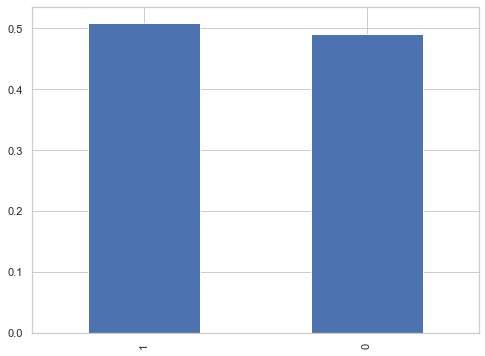

In [88]:
frequency = data['at_fault'].value_counts(normalize=True)
print(frequency)
plt.rcParams["figure.figsize"] = (8, 6)
frequency.plot(kind='bar');

Дисбаланс отсутсвует, 51% приходится на отсутсвие вины.

Выделим целевой признак.

In [89]:
features = data.drop('at_fault', axis=1)
target = data['at_fault']

Зададим константу для фиксирования случайного состояния.

In [90]:
RANDOM_STATE = 12345

Целевой признак выделили, произведём разделение данных на две выборки: тренировочную и тестовую. Разделим в следующем соотношении - 75% тренировочная выборка и 25% тестовая.

In [91]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [92]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(40518, 10)
(13507, 10)
(40518,)
(13507,)


Разделение выполнили и проверили размеры выборок. Всё корректно.

У нас только один столбец содержит численные данные, остальные категориальные. Обработаем категориальные признаки техникой прямого кодирование (OHE) и выполним масштабирование численного с помощью StandardScaler.

In [93]:
categorical = features_train.select_dtypes(include=['object']).columns.to_list()
numeric = ['vehicle_age']

In [94]:
ohe_train = features_train.copy()
ohe_test = features_test.copy()

In [95]:
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ohe_encoder.fit(ohe_train[categorical])

ohe_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(ohe_train[categorical])
ohe_train = ohe_train.drop(categorical, axis=1)
ohe_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(ohe_test[categorical])
ohe_test = ohe_test.drop(categorical, axis=1)

In [96]:
ohe_scaler = StandardScaler()
ohe_train[numeric] = ohe_scaler.fit_transform(ohe_train[numeric])
ohe_test[numeric] = ohe_scaler.transform(ohe_test[numeric])

In [97]:
ohe_train.head()

,vehicle_age,control_device_none,control_device_not functioning,control_device_not stated,control_device_obscured,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,lighting_not stated,...,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_not stated,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_not stated,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,vehicle_transmission_manual,vehicle_transmission_not stated
168113,-1.254559,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2506,-0.931447,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
92969,1.330332,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49564,-0.285224,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23928,0.037887,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [98]:
ohe_test.head()

,vehicle_age,control_device_none,control_device_not functioning,control_device_not stated,control_device_obscured,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,lighting_not stated,...,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_not stated,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_not stated,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,vehicle_transmission_manual,vehicle_transmission_not stated
4477,-0.608336,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42390,-0.608336,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
134855,0.037887,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
174636,-0.608336,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
157766,1.976555,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Подготовили данные, выделили целевой признак, сделали разибие на выборки, провели кодирование и масштабирование. Можем приступать к обучению моделей.

Перед нами стоит задача классификации, посмотрим как различные модели справляются с тренировочными данными. Подбор гиперпараметров будем выполнять с помощью кросс-валидации GridSearchCV, данный метод позволяет нам не выделять отдельную валидационную выборку, вместо это в процессе обучения часть данных из тренировочной будут выполнять эту функцию.

В качестве метрики качества будем использовать Recall так как в случае ошибки мы больше заинтересованы сделать false positive предсказание чем false negative.

<a id='log_reg'></a>
### Логистическая Регрессия

In [99]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

params = {
          'max_iter': [500, 1000, 1500],
          'class_weight': [None, 'balanced'],
          'solver': ['liblinear', 'saga'],
          'penalty': ['l1', 'l2'],
          'C': [0.001, 0.01, 0.1, 1]
         }

lr_model = LogisticRegression(random_state=RANDOM_STATE)

lr_model_cv = GridSearchCV(estimator = lr_model, 
                           param_grid = params, 
                           scoring= 'recall', 
                           cv = folds, 
                           verbose = 1,
                           return_train_score=True)

lr_model_cv.fit(ohe_train, target_train)

best_lr_params = lr_model_cv.best_params_
best_lr_model = lr_model_cv.best_estimator_

print("Best Parameters:", best_lr_params, '\n')
print('Recall on training data: ', lr_model_cv.best_score_, '\n')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'C': 0.001, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'} 

Recall on training data:  0.5434402049888953 

CPU times: total: 2min 37s
Wall time: 2min 37s


<a id='dt'></a>
### Древо Решений

In [100]:
samp_leafs = list(range(1, 11, 2))
samp_split = list(range(2, 11, 2))
max_depth = [2, 3, 5, 9, 18]

print(samp_leafs)
print(samp_split)

[1, 3, 5, 7, 9]
[2, 4, 6, 8, 10]


In [101]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {
          'min_samples_leaf': samp_leafs,
          'min_samples_split': samp_split,
          'max_depth': max_depth,        
         }

dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_model_cv = GridSearchCV(estimator = dt_model, 
                           param_grid = params, 
                           scoring= 'recall', 
                           cv = folds, 
                           verbose = 1,
                           return_train_score=True)

dt_model_cv.fit(ohe_train, target_train)

best_dt_params = dt_model_cv.best_params_
best_dt_model = dt_model_cv.best_estimator_

print("Best Parameters:", best_dt_params, '\n')
print('Recall on training data: ', dt_model_cv.best_score_, '\n')

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2} 

Recall on training data:  0.5569243290939145 

CPU times: total: 32.2 s
Wall time: 32.3 s


<a id='rf'></a>
### Случайный Лес

In [102]:
n_estimators = list(range(100, 251, 20))

print(n_estimators)

[100, 120, 140, 160, 180, 200, 220, 240]


In [103]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {
          'n_estimators': n_estimators,          
         }

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_model_cv = GridSearchCV(estimator = rf_model, 
                           param_grid = params, 
                           scoring= 'recall', 
                           cv = folds, 
                           verbose = 1,
                           return_train_score=True)

rf_model_cv.fit(ohe_train, target_train)

best_rf_params = rf_model_cv.best_params_
best_rf_model = rf_model_cv.best_estimator_

print("Best Parameters:", best_rf_params, '\n')
print('Recall on training data: ', rf_model_cv.best_score_, '\n')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'n_estimators': 140} 

Recall on training data:  0.5299478449398712 

CPU times: total: 2min 20s
Wall time: 2min 20s


<a id='catboost'></a>
### Catboost

In [104]:
%%time

folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4 , 0.5],
    'verbose': [False]
}

catboost_model = CatBoostClassifier()

catboost_model_cv = GridSearchCV(estimator=catboost_model,
                                 param_grid=param_grid,
                                 scoring='recall',
                                 cv=folds,
                                 verbose = 1,
                                 return_train_score=True)

catboost_model_cv.fit(ohe_train, target_train)

best_params = catboost_model_cv.best_params_
best_cat_model = catboost_model_cv.best_estimator_

print("Best Parameters:", best_params, '\n')
print('Recall on training data: ', mean(catboost_model_cv.cv_results_['mean_train_score']), '\n')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'learning_rate': 0.1, 'verbose': False} 

Recall on training data:  0.5634295909294186 

CPU times: total: 43min 52s
Wall time: 2min 19s


<a id='best_model'></a>
### Лучшая модель на тестовых данных

Остановимся на модели Логистическая Регрессия. Посмотрим как она поведёт себя на тестовой выборке.

In [105]:
predictions = best_lr_model.predict(ohe_test)
recall = recall_score(target_test, predictions)
print(recall)

0.5328870779976718


Результат сопостовим с тем что мы получили при подборе параметров кросс-валидацией на тренировочных данных.

In [106]:
conf_matrix = confusion_matrix(target_test, predictions)

print('Матрица ошибок:', '\n' , conf_matrix)

Матрица ошибок: 
 [[4567 2068]
 [3210 3662]]


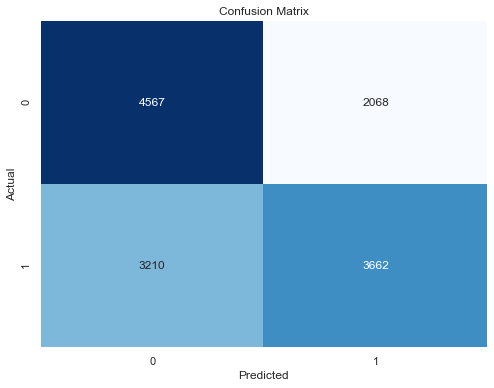

In [107]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

По матрице ошибок видим что модель предсказала риск аварии в примерно 5700, а отсутсвия риска в примерно 7700 случаев. При этом в 3210 случаях модель предсказывала отсутсвие риска в то время когда он там был. Учитывая что нам важно минимизировать False Negative значения можем сделать вывод что модель показала не очень хорошие результаты.

In [108]:
precision = precision_score(target_test, predictions)

print('Точность:', precision)
print('Полнота:', recall)

Точность: 0.6390924956369982
Полнота: 0.5328870779976718


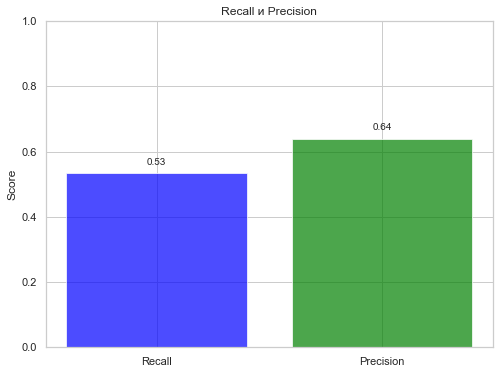

In [109]:
labels = ['Recall', 'Precision']
values = [recall, precision]

x = np.arange(len(labels))

plt.bar(x, values, align='center', alpha=0.7, color=['blue', 'green'])
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Recall и Precision')

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

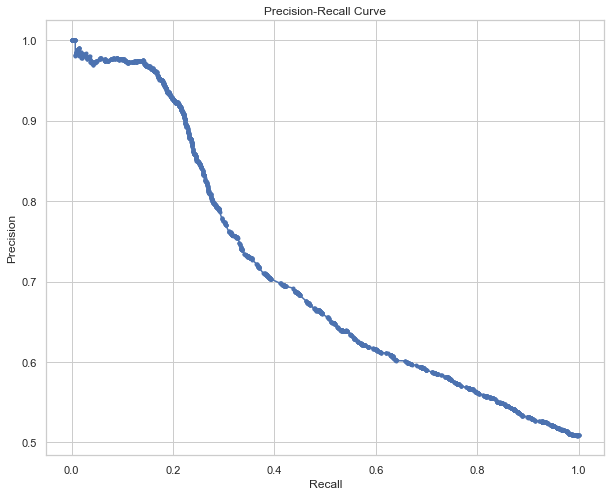

In [110]:
probas_pred = lr_model_cv.predict_proba(ohe_test)[:, 1]

precision_vals, recall_vals, _ = precision_recall_curve(target_test, probas_pred)

plt.figure(figsize=(10, 8))
plt.plot(recall_vals, precision_vals, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [111]:
chart_data = [
              ["Логистическа регрессия", lr_model_cv.best_score_, recall],
              ["Древо решений", dt_model_cv.best_score_, "-"],
              ["Случайный Лес", rf_model_cv.best_score_, "-"],
              ["Catboost", mean(catboost_model_cv.cv_results_['mean_train_score']), "-"]
]

headers = ["Модель", "Recall на тренировочный данных", "Recall на тестовых данных"]

chart = pd.DataFrame(chart_data, columns=headers)

display(chart)

,Модель,Recall на тренировочный данных,Recall на тестовых данных
0,Логистическа регрессия,0.543440,0.532887
1,Древо решений,0.556924,-
2,Случайный Лес,0.529948,-
3,Catboost,0.563430,-


<a id='model_conclusion'></a>
### Вывод по модели оценки риска

Выбрали признаки по которым предположительно можем предсказать есть ли риск ДТП. Запросом получили нужные данные из базы, учитывая следующие требования:
- Тип виновника car
- Исключить ДТП с типом повреждения scratch
- Данные взять только 2012 год.
- В датафрейме должен присутствывать возраст автомобиля.

Сделали дополнительную обработку датафрейма, посмотрели на баланс целевого признака, дисбаланс отсутсвует. Разделили данные на две выборки: тренировочная и тестовая в соотношении 75%/25%. Закодировали категориальные признаки прямым кодированием и сделали масштабирование численных.

В качестве метрики качества выбрали Recall, это значит что нам важно избежать случаев когда вероятность аварии действительно есть, но модель предсказывает что никаких рисков нет (False Negative), вместо этого модель чаще может неправильно предсказывать случаи когда риска нету, но модель предположит что он есть (False Positive).

Выбрали 4 модели: Логистическая Регрессия, Древо решений, Случайный Лес, Catboost. Сделали подборку гиперпараметров с помощью GridSearchCV. Остановились на модели Логистическа Регрессия. Проверили её на тестовых данных, результат не сильно хуже оказался, что говорит о том что модель не переобучена. Все модели показали схожие результаты, Логистическая регрессия на тесте показала Recall = 0.53. Можем сделать вывод что этот результат нельзя назвать хорошим, но и однозначно плохим тоже.

<a id='factors_analysis'></a>
## Проведём анализ важности факторов ДТП

Выведим список всех признаков в порядке влияния на целевой признак.

In [112]:
coef_abs = abs(best_lr_model.coef_[0])
feature_importances_lr = coef_abs / sum(coef_abs)

feature_names = ohe_train.columns.tolist()

sorted_indices = np.argsort(feature_importances_lr)[::-1]
sorted_importances = feature_importances_lr[sorted_indices]

for i, idx in enumerate(sorted_indices):
    print(f"{i + 1}. {feature_names[idx]}: {sorted_importances[i]}")

1. party_sobriety_had been drinking, under influence: 0.17962700576681687
2. party_sobriety_had not been drinking: 0.16481302391029098
3. control_device_none: 0.0667903772662549
4. party_sobriety_not applicable: 0.06024832996567055
5. party_drug_physical_not applicable: 0.06024832996567055
6. vehicle_transmission_manual: 0.04773239950061924
7. road_surface_wet: 0.04285767712862183
8. party_drug_physical_under drug influence: 0.04272773899754665
9. party_drug_physical_not stated: 0.040476996602912256
10. party_drug_physical_sleepy/fatigued: 0.03000324837675413
11. vehicle_age: 0.02911747742071551
12. lighting_dark with street lights: 0.027976077858682835
13. lighting_daylight: 0.02778585162546076
14. party_sobriety_impairment unknown: 0.024441097765279394
15. weather_1_cloudy: 0.021206639520107897
16. location_type_ramp: 0.021168942297170215
17. road_surface_snowy: 0.018696251504891785
18. weather_1_raining: 0.014966044863660634
19. party_sobriety_had been drinking, not under influence:

Получили список со всеми признаками. Видим что два самых важных признака: "Состояние участника: физическое или с учётом принятых лекарств" и "Трезвость участника". Трезвость мы разобрали ранее на этапе работы с базой, тогда мы выявили что он влияет на аварийность и теперь результаты модели подтверждают это. 

Посмотрим на **party_drug_physical**.

In [113]:
data_fault = data.query('at_fault > 0')

fault_plot = data_fault.groupby('party_drug_physical').agg(at_fault=('at_fault', 'count'))
plot = data.groupby('party_drug_physical').agg(at_fault_total=('at_fault', 'count'))
party_drug_physical_plot = pd.concat([plot, fault_plot], axis=1)

In [114]:
party_drug_physical_plot['perc_of_fault'] = (party_drug_physical_plot['at_fault'] \
                                             / party_drug_physical_plot['at_fault_total']) * 100

party_drug_physical_plot = party_drug_physical_plot.sort_values(by='perc_of_fault', ascending=False)
display(party_drug_physical_plot)

,at_fault_total,at_fault,perc_of_fault
party_drug_physical,,,
sleepy/fatigued,370,368,99.459459
impairment - physical,57,52,91.228070
under drug influence,868,767,88.364055
G,1108,855,77.166065
not stated,50978,25400,49.825415
not applicable,644,98,15.217391


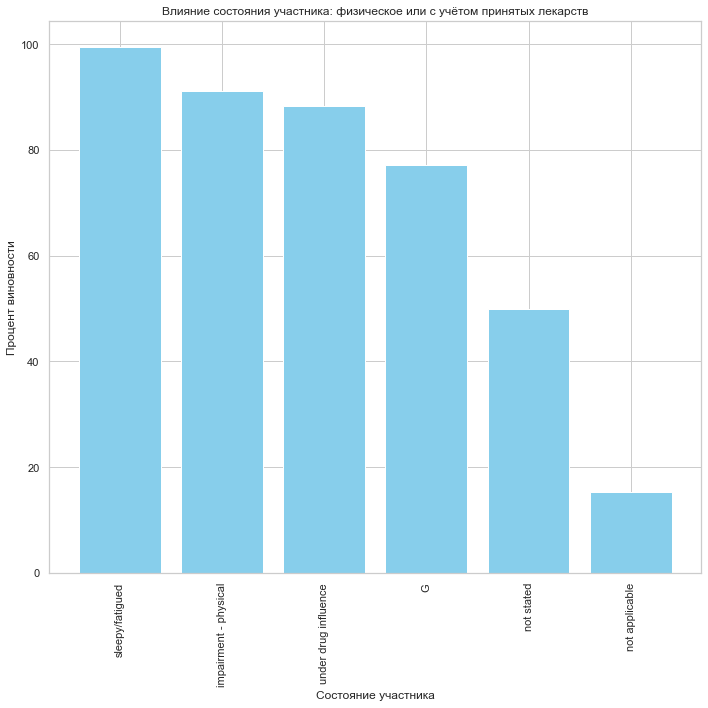

In [115]:
plt.figure(figsize=(10, 10))
plt.bar(party_drug_physical_plot.index, party_drug_physical_plot['perc_of_fault'], color='skyblue')
plt.xlabel('Состояние участника')
plt.ylabel('Процент виновности')
plt.title('Влияние состояния участника: физическое или с учётом принятых лекарств')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

В 99% если водитель был "Сонный/Усталый" это привело к аварийной ситуации. Видим что в тех случаях когда водитель не оценивался или не известно влияние процент намного ниже.

Выясняли что данный фактор имеет большой вес в предсказании риска аварии. Как либо серьезно проанализировать водителя во время посадки на данные факторы сложно. Можно оборудовать камеру в салоне направленую на водителя и по внешнему состоянию определить сонные у него глаза/лицо, но такой способ не сработает если человек принимал какие-либо препараты действие которых внешне не выраженно. Ну и оборудовав камеру в салоне мы может быть немного уменьшим количество аварий связаных с усталостью/сонливостью, мы определенно существенно уменьшим колличество клиентов которые будут пользоваться услугами компании, а не конкурентами, если есть выбор воспользоваться каршерингом где на тебя будет направлена камера во время поездки и где её не будет очевидно что большинство предпочтёт второй выбор.

<a id='conclusion'></a>
## Выводы

Перед нами стояла задача поработать с данными по дорожно транспортным происшествиям и понять возможно ли создать систему которая сможет оценить вероятность риска дтп в момент когда водитель садится за руль и прокладывает маршрут.

Мы изучили базу данных, проанализировали влияние различных признаков, построили графики и поручили коллегам 6 задач для анализа. Часть из них мы разобрали выше. Выбрали признаки которые предположительно могут нам помочь в предсказании риска аварии и сформировали датасет с выгруженными данными из базы данных. Сделали обработку данных и подготовили две выборки для обучения и тестирования модели. Использовали полноту в качестве метрики качества и в итоге остановились на модели Линейная Регрессия.

Логистическая регрессия показала следующие результаты: 
- Recall на тренировочных данный = 0.543
- Recall на тестовых данный = 0.533
- Precision на тестовых данный = 0.639

Мы так же изучили матрицу ошибок, посмотрели на кривую точность-полнота. Результаты нельзя назвать хорошими, но возможно при большем количестве данных и дополнительных важных признаках, можно улучшить результат.

Посмотрели какие факторы больше всего оказывают влияние на аварии: "Состояние участника: физическое или с учётом принятых лекарств" и "Трезвость участника" имеют большое влияние.

Можем сделать следующие выводы:
- В данной задаче слишком много чего может пойти не так, предсказать опасный ли маршрут крайне сложная задача, многие факторы могут часто меняться. Например мы смотрели данные за 1 год (2012), но потом могли произойти какие-то серьезные изменения, например поставили светофор или убрали с какого-то учаска, тоже самое с отбойниками или знаками. Возможно заменили покрытие дороги на другое или наоборот мы учитывали что дорога в отличном состоянии (на тот момент когда данные собраны), а в реальности она сильно ухудшилась.
- Как мы высняли самый решающий фактор это состояние водителя. Оценить водителя при посадке в каршеринговую машину не так и просто, можно конечно поставить анализатор алкогольного опьянения с обязательным условием его использования, но опять же нам надо видеть что водитель дышит, а не кто-то другой, то есть нужна камера. Камера может снизить привлекательность кампании в глазах клиентов и они предпочтут воспользоваться услугами конкурентов. Так же, как убедится что это водитель дышит? Может его трезвый друг подышит, заведёт машину, проедет метр и они поменяются местами, за руль сядет пьяный водитель. Про факторы где человек находится по влиянием лекарств даже смысла говорить нет, это нереально проверить дистанционно.
- Заказчик просил учесть фактор возраста авто, мы его расмотрели до построения модели и определили что он имеет незначительное влияние. После того как обучили модель так же посмотрели какие факторы имеют большее и меньшее влияние, данный фактор оказался на 11 месте из 45.
- Из того что можем предложить для создания данной модели: создать базу пользователей каршеринга в которой учесть различные факторы, например попадал ли в аварию, с какой средней скоростью обычно перемещается, какой водительский стаж, возраст водителя и тд тп. Всё это в конечном итоге может влиять на стиль вождения который может являться более рискованым или наоборот безопасным. В дальнейшем используя эту базу мы сможем предположить стиль вождения нового клиента. Всё это можно будет объеденить с признаками из базы по происшествиям, получится как стиль водителя + маршут будут учитываться. Ещё можем предложить использовать координаты географические в базе происшествий. Там есть название района и численное обозначение, но это слишком расплывчатая информацыя чтобы её можно было адекватно тут использовать.

В общем, удалось создать модель среднего качества, но недостаточного для адекватного использования, но выше есть пару рекомендаций которые могут помочь в этом направлении.